# Tarea 5

**Autor:** Alejandro Zarate Macias  
**Curso:** Métodos Matemáticos para Análisis de Datos  
**Fecha:** 22 de Septiembre 2025

---

## Introducción

En este notebook se abordan los problemas 1-6 de la Tarea 5, en los que se requiere la implementacion de algoritmos Gauss-Newton, SGD y ADAM, con el objetivo de comparar su rendimiento en diferentes escenarios de optimización.

---

## Importante

Las funciones 
- $f(x)$
- $h(x_i, \theta)$
- $Loss$
- $Cost$ 

se utilizan a lo largo de diferentes problemas. Por lo tanto, se definen al inicio del notebook para evitar redundancia en el código.

In [67]:
import numpy as np                  # Para manejo de arreglos
import matplotlib.pyplot as plt     # Para graficar
from typing import Callable         # Para anotaciones de tipos 

### Para todos los problemas

In [68]:
def f(x):
    # Retornar la funcion f(x) = 2^(cos(x^2)) evaluada en x
    return 2**(np.cos(x**2))

def h(x_i, theta):
    # Evaluar el polinomio con coeficientes theta en el punto x_i
    y_hat = 0
    for i in range(len(theta)):
        y_hat += theta[i]*(x_i**i)
    return y_hat

def h_vec(x, theta):
    # Evaluar el polinomio con coeficientes theta en todos los puntos de x
    return [h(x_i, theta) for x_i in x]

def loss(y, y_hat):
    # Calcular el loss cuadratico entre "y" y "y_hat"
    return (y - y_hat)**2

def cost(y, y_hat):
    # Calcular MSE (Mean Squared Error)
    m = len(y)
    return (1/m) * np.sum(loss(y,y_hat))


### Para Gauss Newton

In [69]:
def J(x,N):
    # Calcular la matriz Jacobiana J
    return np.stack([x**k for k in range(N+1)], axis=1)

def grad_gn(x,y,theta):
    # Calcular el gradiente para el metodo de Gauss-Newton
    m = len(y)
    y_hat = h_vec(x, theta)
    r = y - y_hat
    J_mat = J(x, len(theta)-1)
    return (-2/m) * J_mat.T @ r


### Para SGD y ADAM

In [70]:
def grad_theta(X, y, theta):
    # Calcular el gradiente del costo con respecto a los parametros theta
    X = np.array(X)
    y = np.array(y)
    theta = np.array(theta)
    m = len(y)
    y_hat = h_vec(X, theta)
    gradient = np.zeros(len(theta))
    for j in range(len(theta)):
        gradient[j] = (-2/m) * np.sum((y - y_hat) * (X**j))
    return gradient


---

# Problema 1

Considere la siguiente función

$f(x) = 2^{cos(x^2)}, \quad x \in (-\pi,\pi).$

A continuación, haga lo siguiente:


- Calcule 500 pares de datos de muestra $D = {x_i,f(x_i)}$ donde los $x_i$ están equiespaciados.
- Realice un gráfico de $D$.
- Considere un modelo polinomial de grado $\mathcal{N}$:
    
    $h(x_i, \theta) = \hat{y_i} = \sum^{\mathcal{N}}_{\ell=0}\theta_{\ell}x^{\ell}_{i}, \quad \theta=(\theta_{0}, \theta_{1}, \theta_{2}, ...,\theta_{\mathcal{N}}) \in \mathbb{R}^{\mathcal{N}+1}.$
    
- Considere una función de pérdida y costo de MSE:

    $Loss(y_i, \hat{y_i}) = (y_i - \hat{y_i})^2,$

    $Cost(\theta;D) = \frac{1}{m}\sum^{m}_{i=1}Loss(y_i, \hat{y_i})$
    
- Codifique un script en Python para resolver el problema de optimización asociado utilizando un algoritmo de búsqueda lineal determinista. Puede probar $\mathcal{N}$ = 8, por ejemplo.
- Haz una gráfica de la solución contra $f(x_i)$ y muestra en otra gráfica cómo el costo disminuye a medida que pasan las iteraciones.


## Métodos

In [71]:
class GaussNewton:
    def __init__(self, 
                 grad:Callable,
                 h:Callable,
                 J:Callable):
        self.grad = grad
        self.h = h
        self.J = J

    def optimize(self, 
                 X:np.array, 
                 y:np.array, 
                 theta_0:np.array,
                 N:int, 
                 alpha:float = 1e-3,
                 max_iter:int = 1000, 
                 tol:float = 1e-5,
                 verbose:bool = True):
        
        x = X.copy()
        theta = theta_0.copy()
        alpha_k = alpha
        cost_history = []

        for i in range(max_iter):
            # Compute cost
            y_hat = h_vec(x, theta)
            cost_history.append(cost(y, y_hat))
            # Verify stop criteria
            grad_k = self.grad(x, y, theta)
            if np.linalg.norm(grad_k) < tol:
                print(f"Convergió en la iteración {i}")
                break
            # Compute J_k and r_k
            J_k = self.J(x, N)
            h_k = self.h(x, theta)
            r_k = h_k - y
            # Comppute A_k = J_{k}^{T}*J_k 
            A_k = J_k.T @ J_k
            # Compute b_k = -J_{k}^{T}*r_k
            b_k = -J_k.T @ r_k
            # Solve A_k*P_k = b_k
            P_k = np.linalg.solve(A_k, b_k)
            # Compute alpha_k (wolfe conditions)
            alpha_k = self.wolfe_conditions(x, y, theta, P_k, self.grad, alpha_k)
            # theta = theta + alpha_k*P_k
            theta = theta + alpha_k*P_k

            if i % 100 == 0 and verbose:
                print(f"Iteración {i}: Costo = {cost_history[-1]}")

        return theta, cost_history

    @staticmethod
    def wolfe_conditions(x, y, theta, p, grad_func, alpha_init, c1=1e-4, c2=0.9):
        # Calcular alpha usando armijo + curvatura
        alpha = alpha_init
        phi_0 = cost(y, h_vec(x, theta))
        grad_0 = grad_func(x, y, theta)
        phi_alpha = cost(y, h_vec(x, theta + alpha * p))
        # Condicion de Armijo
        while phi_alpha > phi_0 + c1 * alpha * grad_0.T @ p:
            alpha *= 0.5
            phi_alpha = cost(y, h_vec(x, theta + alpha * p))
        grad_alpha = grad_func(x, y, theta + alpha * p)
        # Condicion de Curvatura
        while grad_alpha.T @ p < c2 * grad_0.T @ p:
            alpha *= 1.1
            phi_alpha = cost(y, h_vec(x, theta + alpha * p))
            grad_alpha = grad_func(x, y, theta + alpha * p)
        return alpha

## Resultados

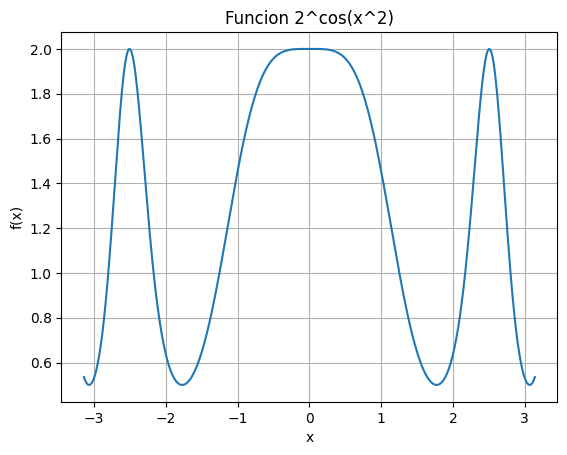

In [72]:
# D = {X, y}
x = np.linspace(-np.pi, np.pi, 500)
y = f(x)

# Plotear la funcion f(x) original
plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Funcion 2^cos(x^2)')
plt.grid()
plt.show()

In [73]:
# Inicializar polinomio de grado N
N = 8
theta0 = np.zeros(N+1)

# Normalizar x para evitar valores grandes
x_norm = x / np.pi

# Inicializacion del algoritmo de Gauss-Newton
gn = GaussNewton(grad=grad_gn, h=h, J=J)
theta, cost_history = gn.optimize(x_norm, y, theta0, N, alpha=0.01, max_iter=2000, tol=1e-8)

# Calcular y_hat con los parametros optimizados
y_hat = h_vec(x_norm, theta)

Iteración 0: Costo = 1.9576816044185634
Iteración 100: Costo = 0.05931420969334668
Convergió en la iteración 170


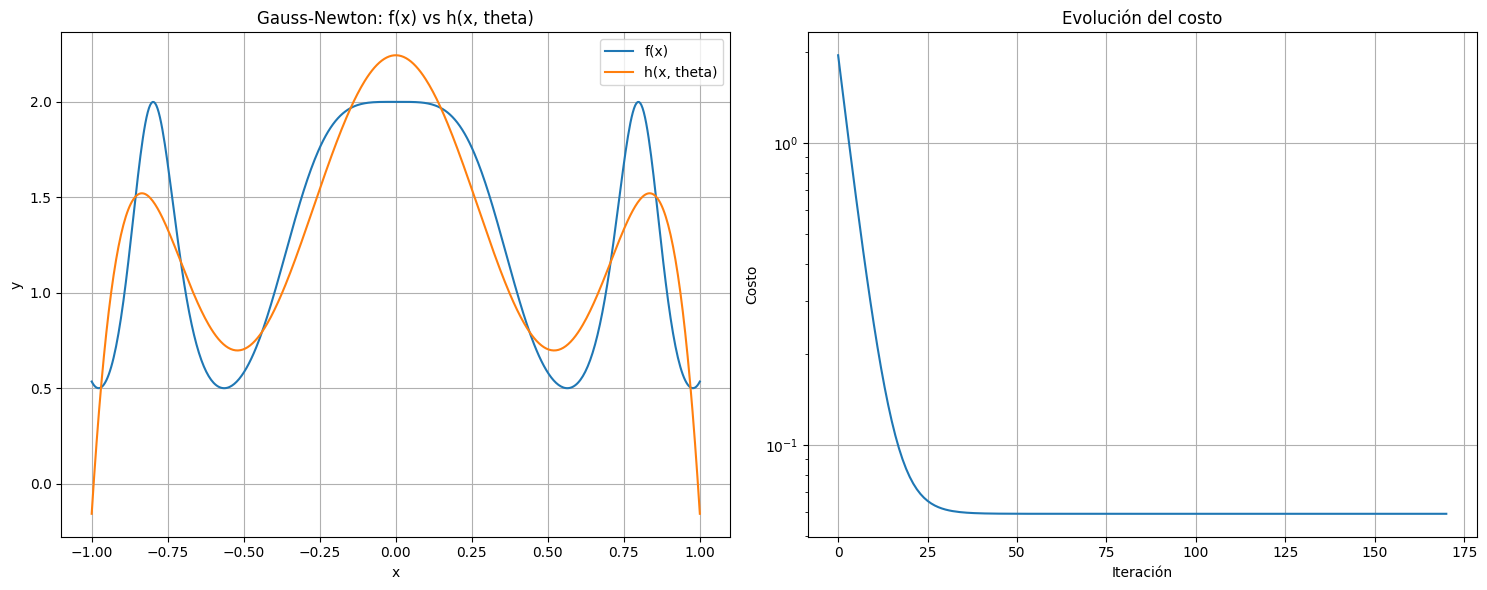

In [74]:
# Crear fig para las graficas
plt.figure(figsize=(15, 6))

# Grafica 1: función original vs función aproximada
plt.subplot(1, 2, 1)
plt.plot(x_norm,y, label='f(x)')
plt.plot(x_norm,y_hat, label='h(x, theta)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gauss-Newton: f(x) vs h(x, theta)')
plt.legend()
plt.grid()

# Grafica 2: Costo durante las iteraciones
plt.subplot(1, 2, 2)
plt.plot(range(len(cost_history)), cost_history)
plt.xlabel('Iteración')
plt.ylabel('Costo')
plt.yscale('log')
plt.title('Evolución del costo')
plt.grid()

plt.tight_layout()
plt.show()

---

# Problema 2

Intenta encontrar un tamaño más adecuado para el modelo paramétrico del problema anterior resolviendo de nuevo varios valores de $\mathcal{N}$. Crea gráficos que muestren tus hallazgos. A partir de aquí, puedes fijar este valor de N para los problemas restantes.

## Métodos

(Los mismos implementados en el problema 1 y de la seccion de "Importante")

## Resultados

In [75]:
# Lista de polinomios a evaluar
N_tests = [2, 4, 8, 12, 16, 20]

# Listas para almacenar costos y predicciones
costs = []
y_hats = []

# Normalizar x para evitar valores grandes
x_norm = x / np.pi

# Inicializacion del algoritmo de Gauss-Newton
gn = GaussNewton(grad=grad_gn, h=h, J=J)

# Evaluacion del algoritmo por polinomio
for N in N_tests:
    print("="*60)
    print(f"EVALUACION CON POLINOMIO DE GRADO {N}")
    print("="*60)
    theta0 = np.zeros(N+1)
    theta, cost_history = gn.optimize(x_norm, y, theta0, N, alpha=0.01, max_iter=2000, tol=1e-8)
    y_hat = h_vec(x_norm, theta)
    costs.append(cost_history)
    y_hats.append(y_hat)
    print("\n")

EVALUACION CON POLINOMIO DE GRADO 2
Iteración 0: Costo = 1.9576816044185634
Iteración 100: Costo = 0.26489127078128755
Convergió en la iteración 170


EVALUACION CON POLINOMIO DE GRADO 4
Iteración 0: Costo = 1.9576816044185634
Iteración 100: Costo = 0.23480076817672235
Convergió en la iteración 170


EVALUACION CON POLINOMIO DE GRADO 8
Iteración 0: Costo = 1.9576816044185634
Iteración 100: Costo = 0.05931420969334668
Convergió en la iteración 170


EVALUACION CON POLINOMIO DE GRADO 12
Iteración 0: Costo = 1.9576816044185634
Iteración 100: Costo = 0.0066454646356668085
Convergió en la iteración 170


EVALUACION CON POLINOMIO DE GRADO 16
Iteración 0: Costo = 1.9576816044185634
Iteración 100: Costo = 0.001389832883539644
Convergió en la iteración 171


EVALUACION CON POLINOMIO DE GRADO 20
Iteración 0: Costo = 1.9576816044185634
Iteración 100: Costo = 0.00016157211572044556
Convergió en la iteración 171




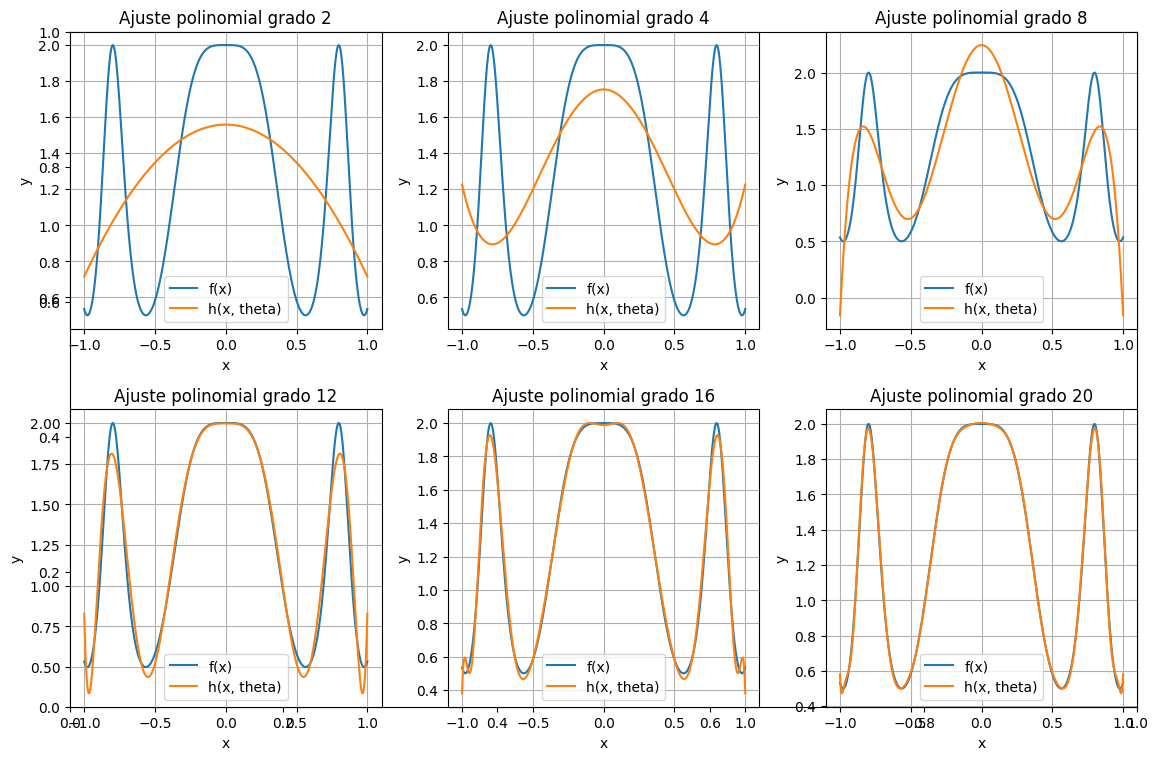

In [76]:
# Graficar resultados de todos los polinomios vs funcion original
fig, ax = plt.subplots(figsize=(12, 8))
for i, N in enumerate(N_tests):
    ax = plt.subplot(2, 3, i+1)
    ax.plot(x_norm, y, label='f(x)')
    ax.plot(x_norm, y_hats[i], label='h(x, theta)')
    ax.set_title(f'Ajuste polinomial grado {N}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid()
plt.tight_layout()
plt.show()

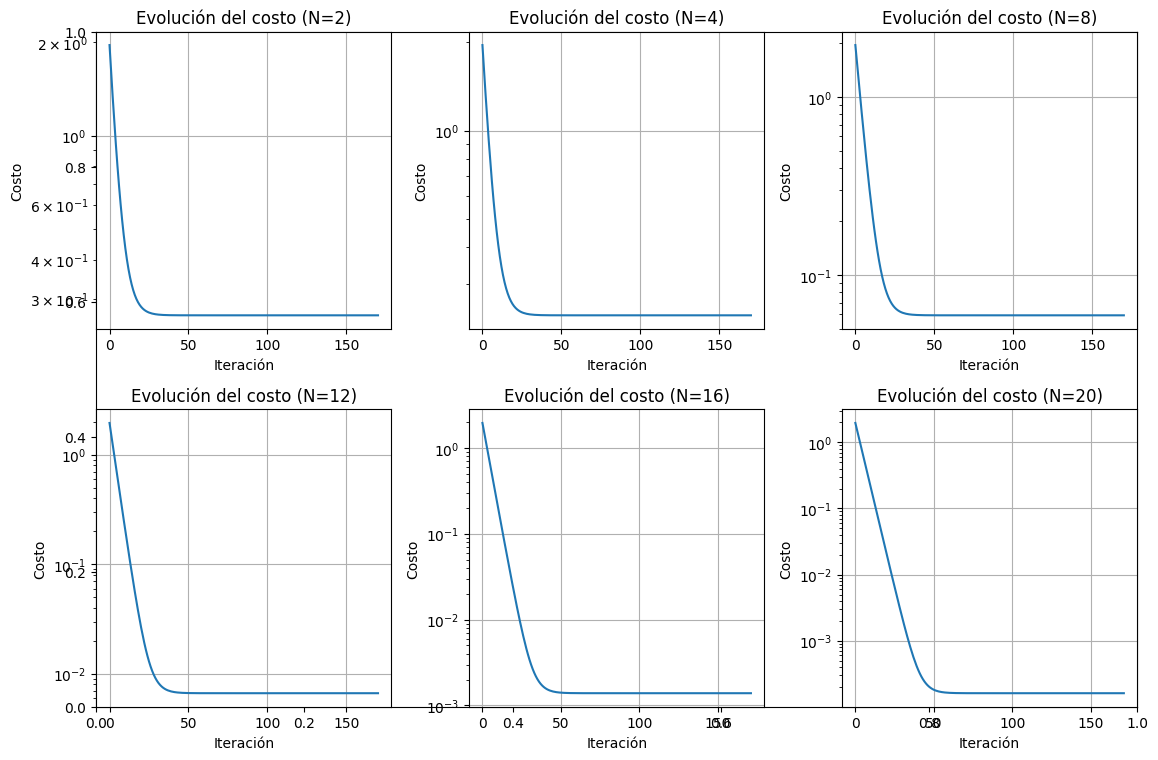

In [77]:
# Graficar el paso del costo para cada polinomio con respecto a las iteraciones
fig, ax = plt.subplots(figsize=(12, 8))
for i, N in enumerate(N_tests):
    ax = plt.subplot(2, 3, i+1)
    ax.plot(range(len(costs[i])), costs[i])
    ax.set_title(f'Evolución del costo (N={N})')
    ax.set_xlabel('Iteración')
    ax.set_ylabel('Costo')
    ax.set_yscale('log')
    ax.grid()
plt.tight_layout()
plt.show()

---

# Problema 3

Cree un script para resolver el Problema 1 utilizando un gradiente descendente de Minibach con una tasa de aprendizaje constante $\alpha$. Genere una gráfica de la solución en función de $f(x_i)$ y muestre en otra gráfica cómo disminuye el coste a medida que transcurren las iteraciones.


## Métodos

In [78]:
class SGD:
    def __init__(self,
                 grad:Callable,
                 h:Callable,
                 cost:Callable):
        self.grad = grad
        self.h = h
        self.cost = cost

    def optimize(self, X, y, theta, alpha=0.01, batch_size=50, epochs=1000, tol=1e-5, verbose=True):
        X = np.array(X)
        y = np.array(y)
        theta = np.array(theta)
        cost_history = []
        for epoch in range(epochs):
            # Split data into batches
            X_batches, y_batches = self.split_batch(X, y, batch_size)

            # Calculate cost of current theta
            cost_i = self.cost(y, self.h(X, theta))
            cost_history.append(cost_i)
            # Print cost every 100 epochs
            if epoch % 100 == 0 and verbose:
                print(f"Epoch {epoch}, Cost: {cost_i}")

            # Stop criteria
            if np.linalg.norm(self.grad(X, y, theta)) <= tol:
                print(f"Converged at epoch {epoch}")
                break
            
            # Step per batch
            for X_batch, y_batch in zip(X_batches, y_batches):
                gradient = self.grad(X_batch, y_batch, theta)
                theta -= alpha * gradient

        return theta, cost_history

    @staticmethod
    def split_batch(X, y, batch_size):
        # Dividir los datos en batches de tamaño batch_size
        X = np.array(X)
        y = np.array(y)
        X_batches = []
        y_batches = []
        for i in range(0, len(y), batch_size):
            X_batches.append(X[i:i+batch_size])
            y_batches.append(y[i:i+batch_size])
        return X_batches, y_batches

## Resultados

In [79]:
# D = {X, y}
x = np.linspace(-np.pi, np.pi, 500, endpoint=False)
y = f(x)

# Normalizar x para evitar valores grandes
x_norm = x / np.pi

# Polinomio de grado N
N = 20
theta_0 = np.zeros(N+1)

# Inicializacion del algoritmo SGD
sgd = SGD(grad=grad_theta, h=h, cost=cost)
theta_optimized, cost_history = sgd.optimize(x_norm, y, theta_0, alpha=0.1, batch_size=50, epochs=2000)

# Hacer predicciones con x normalizado
y_hat = h_vec(x_norm, theta_optimized)

Epoch 0, Cost: 1.961031434293412
Epoch 100, Cost: 0.19260635010197882
Epoch 200, Cost: 0.16070231425828008
Epoch 300, Cost: 0.14548405308344378
Epoch 400, Cost: 0.1351177273728498
Epoch 500, Cost: 0.12645834794759012
Epoch 600, Cost: 0.1186705961381944
Epoch 700, Cost: 0.1115142517736727
Epoch 800, Cost: 0.1049009184937083
Epoch 900, Cost: 0.09878139813056828
Epoch 1000, Cost: 0.0931175880286809
Epoch 1100, Cost: 0.08787564812010151
Epoch 1200, Cost: 0.0830243796205931
Epoch 1300, Cost: 0.07853481455244843
Epoch 1400, Cost: 0.07438005574874654
Epoch 1500, Cost: 0.07053515507943157
Epoch 1600, Cost: 0.06697699241661209
Epoch 1700, Cost: 0.06368415391657911
Epoch 1800, Cost: 0.060636813057021045
Epoch 1900, Cost: 0.057816616951641496


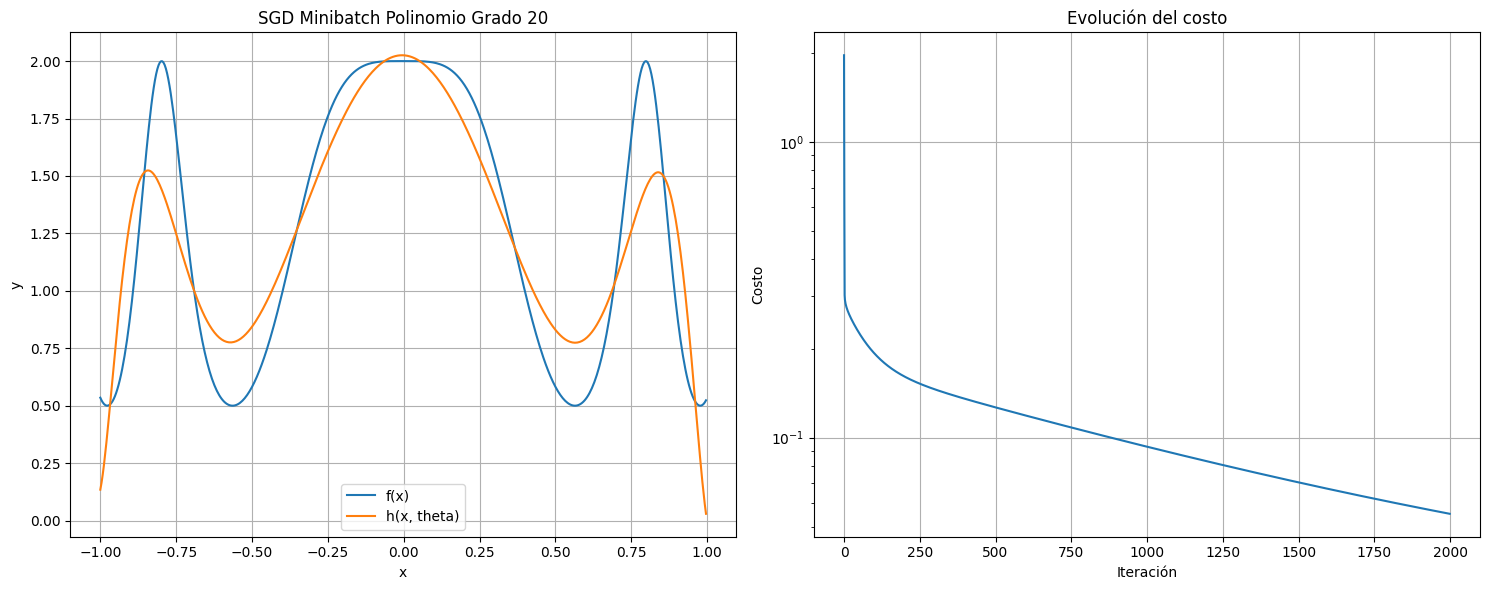

In [80]:
# Crear fig para las graficas
plt.figure(figsize=(15, 6))

# Grafica 1: función original vs función aproximada
plt.subplot(1, 2, 1)
plt.plot(x_norm,y, label='f(x)')
plt.plot(x_norm,y_hat, label='h(x, theta)')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'SGD Minibatch Polinomio Grado {N}')
plt.legend()
plt.grid()

# Grafica 2: Costo durante las iteraciones
plt.subplot(1, 2, 2)
plt.plot(range(len(cost_history)), cost_history)
plt.xlabel('Iteración')
plt.ylabel('Costo')
plt.yscale('log')
plt.title('Evolución del costo')
plt.grid()

plt.tight_layout()
plt.show()

---

# Problema 4

Repita el Problema 3 usando Adam.

## Métodos

In [81]:
class Adam:
    def __init__(self,
                 grad:Callable,
                 h:Callable,
                 cost:Callable):
        self.grad = grad
        self.h = h
        self.cost = cost

    def optimize(self, X, y, theta, alpha=0.01, beta1=0.9, beta2=0.999, batch_size=50, epochs=1000, tol=1e-5, verbose=True):
        X = np.array(X)
        y = np.array(y)
        theta = np.array(theta)
        cost_history = []
        V = np.zeros(len(theta))
        S = np.zeros(len(theta))
        for epoch in range(epochs):
            # Split data into batches
            X_batches, y_batches = self.split_batch(X, y, batch_size)

            # Calculate cost of current theta
            cost_i = self.cost(y, self.h(X, theta))
            cost_history.append(cost_i)
            # Print cost every 100 epochs
            if epoch % 100 == 0 and verbose:
                print(f"Epoch {epoch}, Cost: {cost_i}")

            # Stop criteria
            if np.linalg.norm(self.grad(X, y, theta)) <= tol:
                print(f"Converged at epoch {epoch}")
                break
            
            # Step per batch
            for X_batch, y_batch in zip(X_batches, y_batches):
                V = beta1 * V + (1 - beta1) * self.grad(X_batch, y_batch, theta)
                S = beta2 * S + (1 - beta2) * (self.grad(X_batch, y_batch, theta)**2)
                V_new = V / (1 - beta1**(epoch + 1))
                S_new = S / (1 - beta2**(epoch + 1))
                theta -= alpha * (V_new / (np.sqrt(S_new) + 1e-8))

        return theta, cost_history

    @staticmethod
    def split_batch(X, y, batch_size):
        # Dividir los datos en batches de tamaño batch_size
        X = np.array(X)
        y = np.array(y)
        X_batches = []
        y_batches = []
        for i in range(0, len(y), batch_size):
            X_batches.append(X[i:i+batch_size])
            y_batches.append(y[i:i+batch_size])
        return X_batches, y_batches

## Resultados

In [82]:
# D = {X, y}
x = np.linspace(-np.pi, np.pi, 500, endpoint=False)
y = f(x)

# Normalizar x para evitar valores grandes
x_norm = x / np.pi

# Polinomio de grado N
N = 20
theta_0 = np.zeros(N+1)

# Inicializacion del algoritmo ADAM
adam = Adam(grad=grad_theta, h=h, cost=cost)
theta_optimized, cost_history = adam.optimize(x_norm, y, theta_0, alpha=0.1, beta1=0.9, beta2=0.999, batch_size=50, epochs=2000)

# Hacer predicciones con x normalizado
y_hat = h_vec(x_norm, theta_optimized)

Epoch 0, Cost: 1.961031434293412
Epoch 100, Cost: 0.21056534901411106
Epoch 200, Cost: 0.155410060325398
Epoch 300, Cost: 0.12089688888227446
Epoch 400, Cost: 0.09745420933955384
Epoch 500, Cost: 1.5605508498066056
Epoch 600, Cost: 0.06725221258805439
Epoch 700, Cost: 0.05709885076625306
Epoch 800, Cost: 0.049349442296565973
Epoch 900, Cost: 0.04326937192066471
Epoch 1000, Cost: 0.038484729387071114
Epoch 1100, Cost: 0.03471310679324605
Epoch 1200, Cost: 0.03173951417277374
Epoch 1300, Cost: 0.029397085795605075
Epoch 1400, Cost: 0.02762713026694199
Epoch 1500, Cost: 0.24197189638897948
Epoch 1600, Cost: 0.02505821297932411
Epoch 1700, Cost: 0.024203360998782814
Epoch 1800, Cost: 0.023518416563344132
Epoch 1900, Cost: 0.022970375721521014


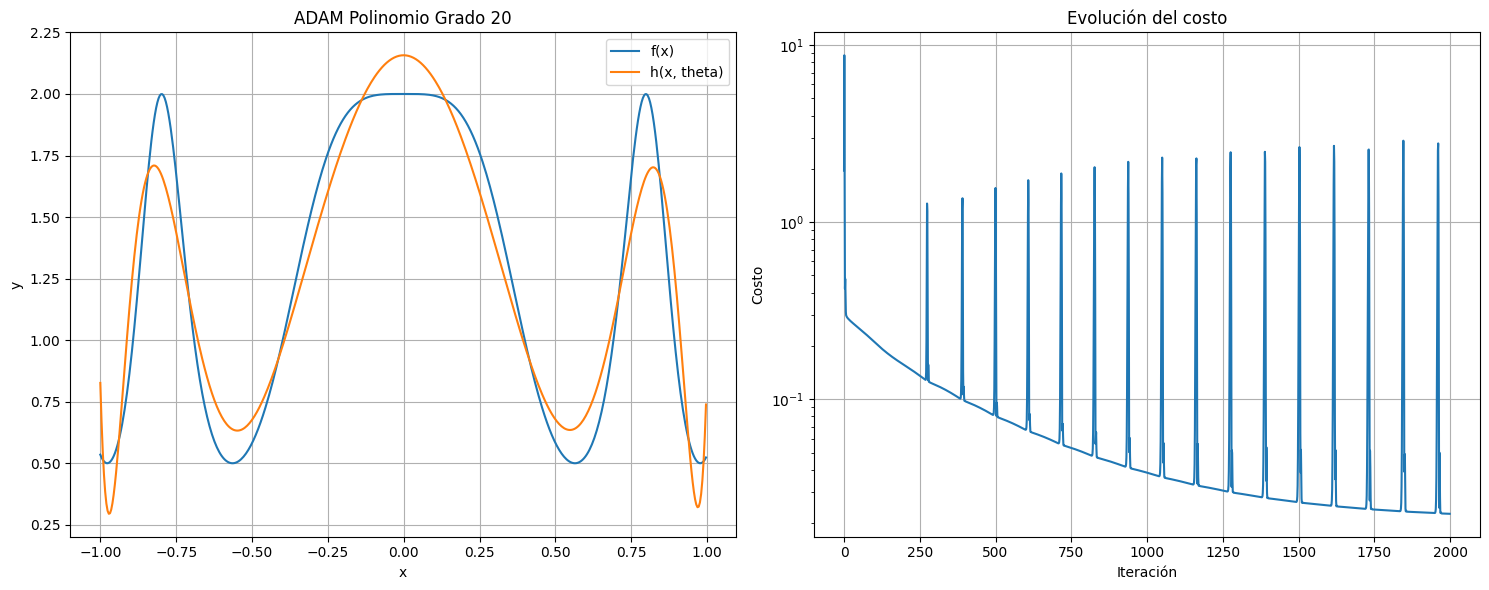

In [83]:
# Crear fig para las graficas
plt.figure(figsize=(15, 6))

# Grafica 1: función original vs función aproximada
plt.subplot(1, 2, 1)
plt.plot(x_norm,y, label='f(x)')
plt.plot(x_norm,y_hat, label='h(x, theta)')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'ADAM Polinomio Grado {N}')
plt.legend()
plt.grid()

# Grafica 2: Costo durante las iteraciones
plt.subplot(1, 2, 2)
plt.plot(range(len(cost_history)), cost_history)
plt.xlabel('Iteración')
plt.ylabel('Costo')
plt.yscale('log')
plt.title('Evolución del costo')
plt.grid()

plt.tight_layout()
plt.show()

---

# Problema 5

Compara las soluciones y el rendimiento de los tres algoritmos que utilizaste para resolver el problema 1. Escribe tus conclusiones y haz algunos gráficos.

## Métodos

(Los mismos implementados en los problemas 1, 3 y 4)

## Resultados

In [84]:
# INICIALIZACION DE DATOS

# D = {X, y}
x = np.linspace(-np.pi, np.pi, 500, endpoint=False)
y = f(x)

# Normalizar x para evitar valores grandes
x_norm = x / np.pi

# Polinomio de grado N
N = 20
theta_0 = np.zeros(N+1)

# Listas para almacenar costos y parametros de los 3 algoritmos
y_hat_list = []
cost_list = []

In [85]:
# GAUSS NEWTON

# Inicializacion del algoritmo Gauss-Newton
gn = GaussNewton(grad=grad_theta, h=h, J=J)
theta_optimized_gn, cost_history_gn = gn.optimize(x_norm, y, theta_0, N, alpha=0.01, max_iter=2000, tol=1e-8)

# Hacer predicciones con x normalizado para Gauss-Newton
y_hat_gn = h_vec(x_norm, theta_optimized_gn)

# Almacenamos resultados de Gauss-Newton
y_hat_list.append(y_hat_gn)
cost_list.append(cost_history_gn)

Iteración 0: Costo = 1.961031434293412
Iteración 100: Costo = 0.00015171058206322178
Convergió en la iteración 171


In [86]:
# SGD

# Inicializacion del algoritmo SGD
sgd = SGD(grad=grad_theta, h=h, cost=cost)
theta_optimized_sgd, cost_history_sgd = sgd.optimize(x_norm, y, theta_0, alpha=0.01, batch_size=50, epochs=2000)

# Hacer predicciones con x normalizado para SGD
y_hat_sgd = h_vec(x_norm, theta_optimized_sgd)

# Almacenamos resultados de SGD
y_hat_list.append(y_hat_sgd)
cost_list.append(cost_history_sgd)

Epoch 0, Cost: 1.961031434293412
Epoch 100, Cost: 0.2709842815975459
Epoch 200, Cost: 0.2570269440749047
Epoch 300, Cost: 0.24574457352937504
Epoch 400, Cost: 0.2359028766253955
Epoch 500, Cost: 0.22713927437917897
Epoch 600, Cost: 0.21928786581341547
Epoch 700, Cost: 0.2122349314749297
Epoch 800, Cost: 0.20588686552743488
Epoch 900, Cost: 0.200162334284236
Epoch 1000, Cost: 0.19498971168619303
Epoch 1100, Cost: 0.19030572714497768
Epoch 1200, Cost: 0.18605445544334948
Epoch 1300, Cost: 0.18218645865031483
Epoch 1400, Cost: 0.1786580330435254
Epoch 1500, Cost: 0.17543054379672543
Epoch 1600, Cost: 0.17246983667251073
Epoch 1700, Cost: 0.16974571786101075
Epoch 1800, Cost: 0.16723149414701974
Epoch 1900, Cost: 0.16490356644871693


In [87]:
# ADAM

# Inicializacion del algoritmo ADAM
adam = Adam(grad=grad_theta, h=h, cost=cost)
theta_optimized_adam, cost_history_adam = adam.optimize(x_norm, y, theta_0, alpha=0.01, beta1=0.9, beta2=0.999, batch_size=50, epochs=2000)

# Hacer predicciones con x normalizado para ADAM
y_hat_adam = h_vec(x_norm, theta_optimized_adam)

# Almacenamos resultados de ADAM
y_hat_list.append(y_hat_adam)
cost_list.append(cost_history_adam)

Epoch 0, Cost: 1.961031434293412
Epoch 100, Cost: 0.27395587640023433
Epoch 200, Cost: 0.22402660926241977
Epoch 300, Cost: 0.1908769301024027
Epoch 400, Cost: 0.16749230011666494
Epoch 500, Cost: 0.14708812112415937
Epoch 600, Cost: 0.1275545566947282
Epoch 700, Cost: 0.10961690669815666
Epoch 800, Cost: 0.0951624290274724
Epoch 900, Cost: 0.08085896428799354
Epoch 1000, Cost: 0.06969089125980137
Epoch 1100, Cost: 0.060256995388456205
Epoch 1200, Cost: 0.052364500326729894
Epoch 1300, Cost: 0.045827092966842176
Epoch 1400, Cost: 0.04060670733869528
Epoch 1500, Cost: 0.036445562304860256
Epoch 1600, Cost: 0.0330274558624381
Epoch 1700, Cost: 0.030250540899066095
Epoch 1800, Cost: 0.02807706227997216
Epoch 1900, Cost: 0.02643003676751229


---

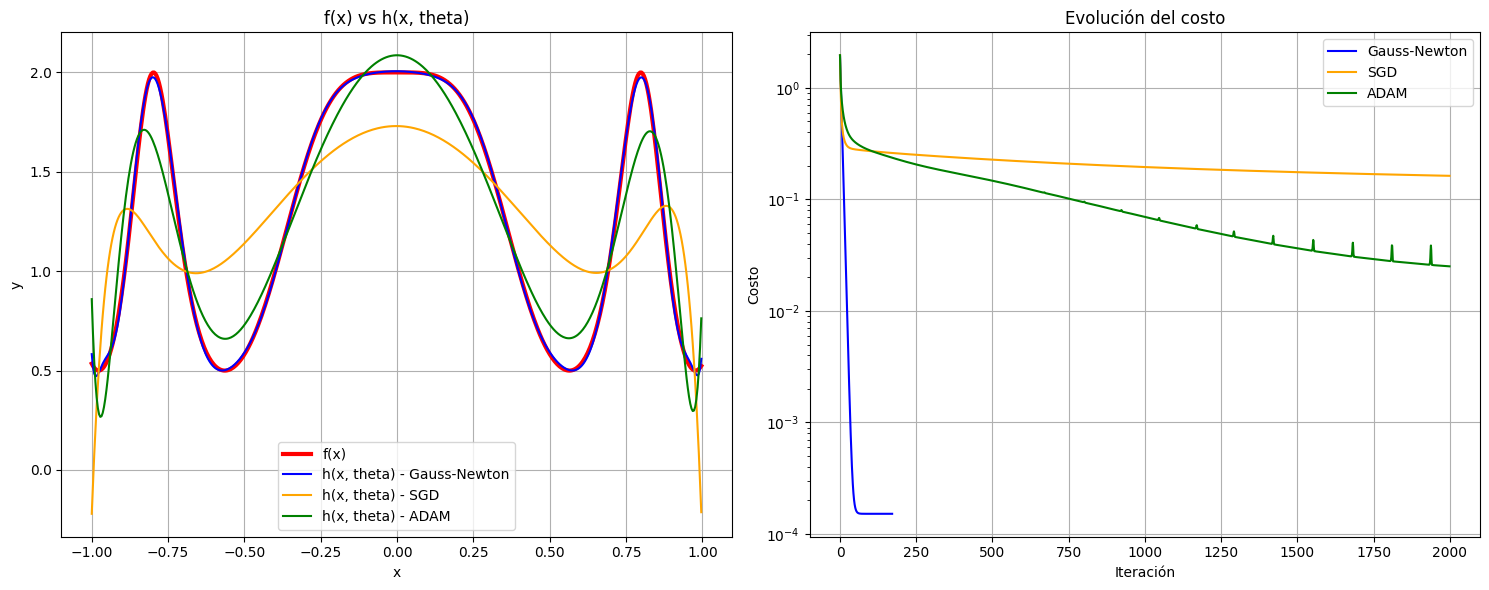

In [88]:
# Comparativa de los 3 algoritmos
algorithms = ['Gauss-Newton', 'SGD', 'ADAM']
colors = ['blue', 'orange', 'green']

plt.figure(figsize=(15, 6))

# Grafica 1: función original vs función aproximada
plt.subplot(1, 2, 1)
plt.plot(x_norm, y, label='f(x)', color='red', linewidth=3)
for i in range(3):
    plt.plot(x_norm, y_hat_list[i], label=f'h(x, theta) - {algorithms[i]}', color=colors[i])
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x) vs h(x, theta)')
plt.legend()
plt.grid()

# Grafica 2: Costo durante las iteraciones
plt.subplot(1, 2, 2)
for i in range(3):
    plt.plot(range(len(cost_list[i])), cost_list[i], color=colors[i], label=algorithms[i])
plt.xlabel('Iteración')
plt.ylabel('Costo')
plt.yscale('log')
plt.title('Evolución del costo')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Problema 6

Hasta ahora has resuelto un problema sin ruido, es decir,

$f(x)=2^{cos(x^2)}+\mathcal{X}, \quad x \in (-\pi,\pi), \mathcal{X} \sim \mathcal{N}(0,\sigma^{2}),$

Donde solo se ha considerado el caso con $\sigma^2=0$. Repita los ejercicios 1 a 5 para los niveles de ruido $\sigma^2 = 0.05,0.1,0.5$. No olvide anotar todas sus conclusiones y reflexiones.

## Métodos

In [89]:
def f_noise(x, sigma_squared=0.0):
    # Retornar la funcion f(x) = 2^(cos(x^2)) evaluada en x con ruido sigma al cuadrado
    base_function = 2**(np.cos(x**2))
    if sigma_squared > 0:
        noise = np.random.normal(0, np.sqrt(sigma_squared), size=x.shape)
        return base_function + noise
    return base_function


## Resultados

In [93]:
# INICIALIZACION DE DATOS

sigma_squared = [0.05, 0.1, 0.5]

# D = {X, y}
x = np.linspace(-np.pi, np.pi, 500, endpoint=False)
y = [f_noise(x, sigma_squared=sigma) for sigma in sigma_squared]

# Normalizar x para evitar valores grandes
x_norm = x / np.pi

# Polinomio de grado N
N = 12
theta_0 = np.zeros(N+1)


EVALUACION CON RUIDO DE VARIANZA 0.05
OPTIMIZANDO CON GAUSS-NEWTON
Convergió en la iteración 170
OPTIMIZANDO CON SGD
OPTIMIZANDO CON ADAM


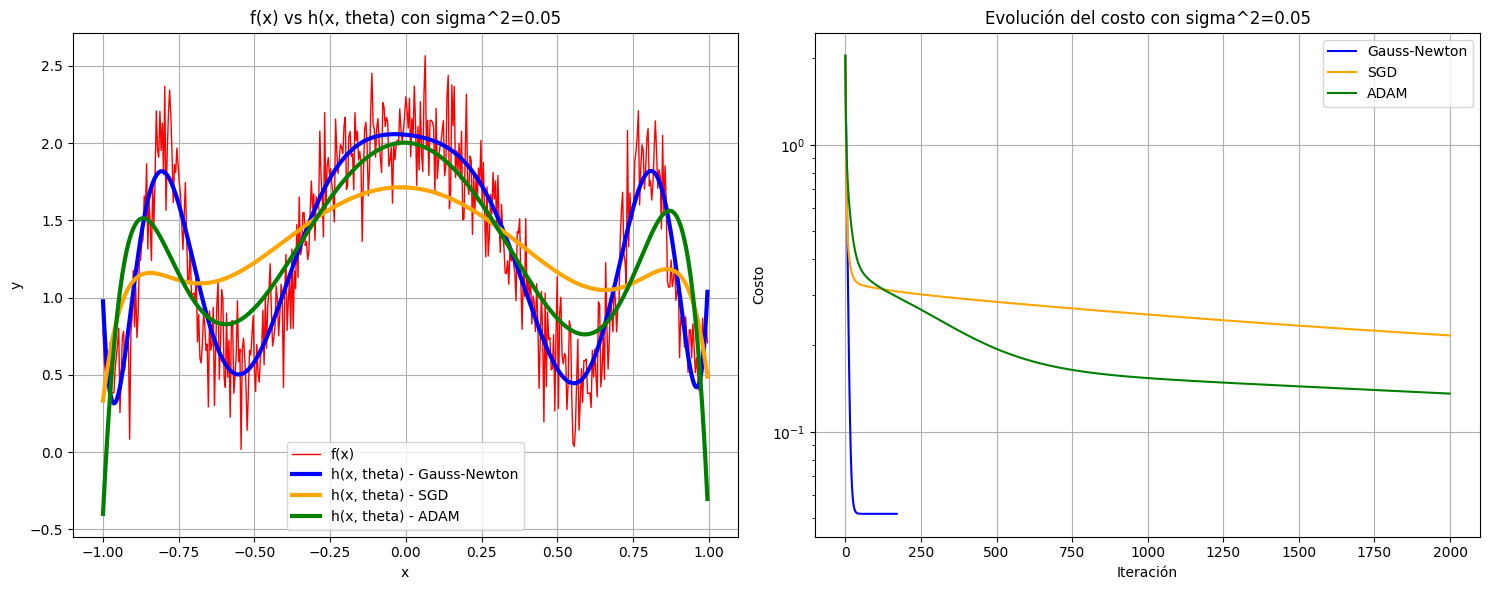

EVALUACION CON RUIDO DE VARIANZA 0.1
OPTIMIZANDO CON GAUSS-NEWTON
Convergió en la iteración 170
OPTIMIZANDO CON SGD
OPTIMIZANDO CON ADAM


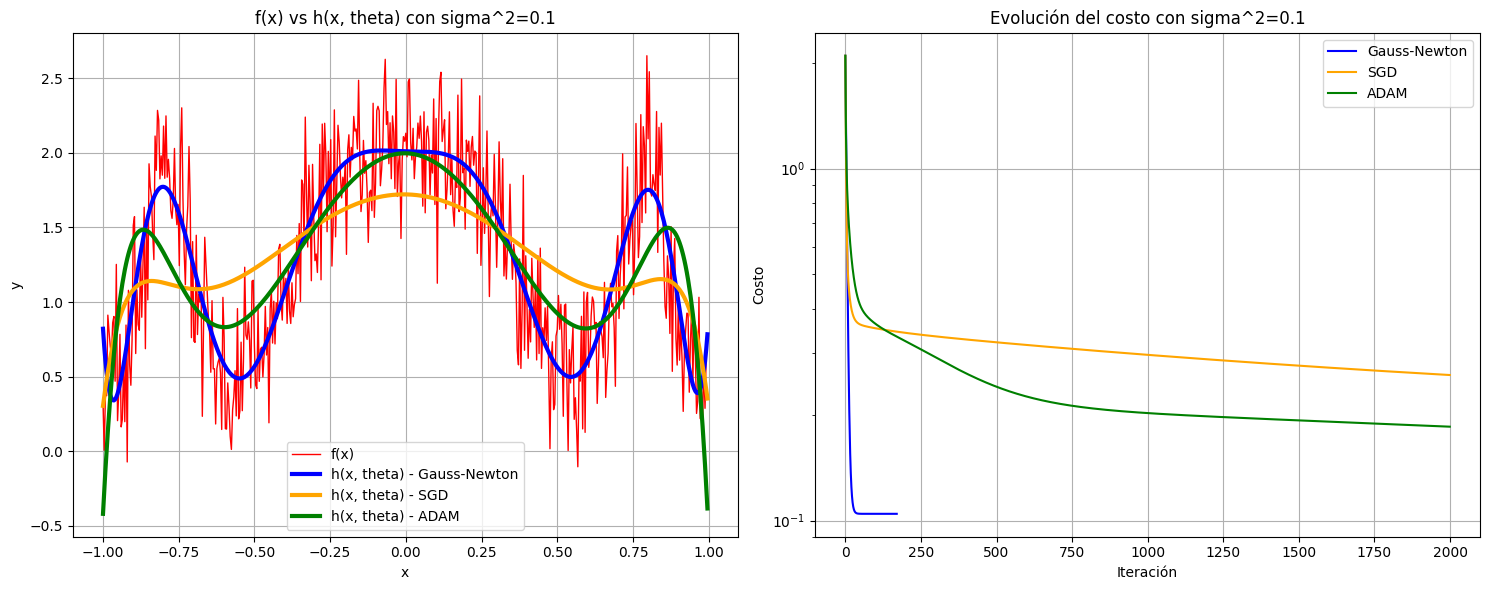

EVALUACION CON RUIDO DE VARIANZA 0.5
OPTIMIZANDO CON GAUSS-NEWTON
Convergió en la iteración 171
OPTIMIZANDO CON SGD
OPTIMIZANDO CON ADAM


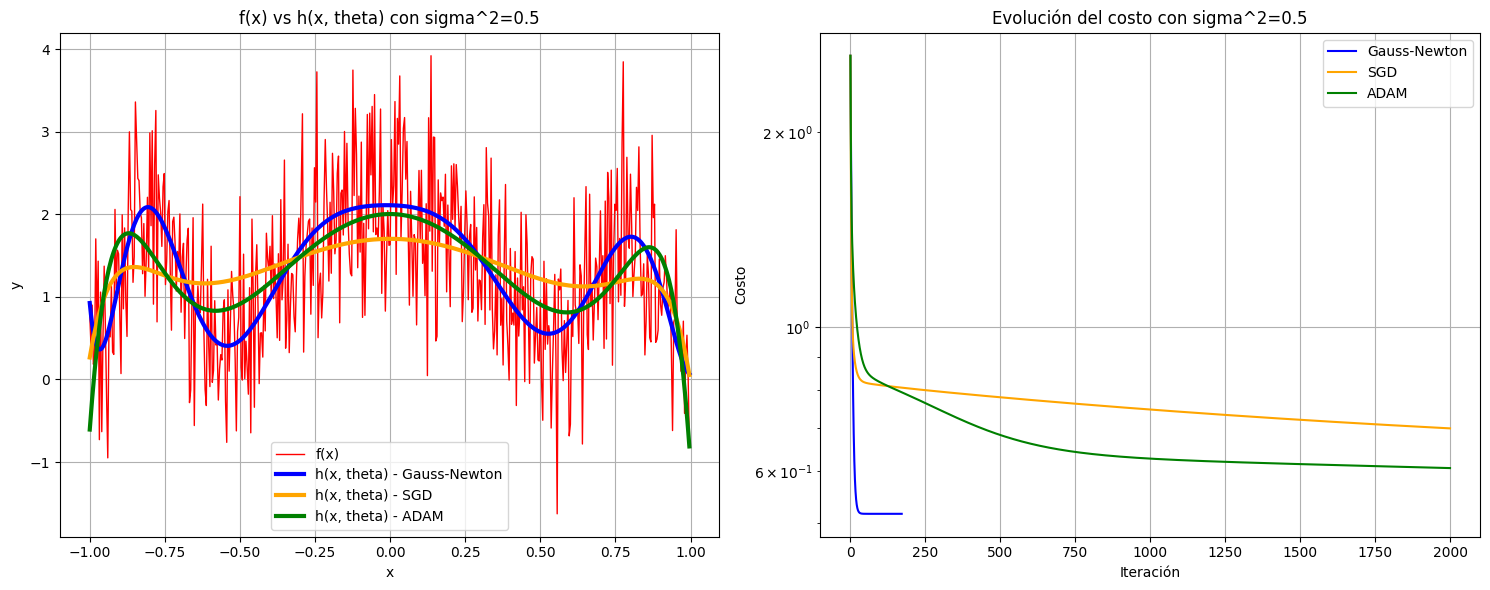

In [94]:
for i, sigma in enumerate(sigma_squared):
    print("="*60)
    print(f"EVALUACION CON RUIDO DE VARIANZA {sigma}")
    print("="*60)
    # Listas para almacenar costos y parametros de los 3 algoritmos
    y_hat_list = []
    cost_list = []

    # GAUSS NEWTON
    print("="*60)
    print(f"OPTIMIZANDO CON GAUSS-NEWTON")
    print("="*60)
    # Inicializacion del algoritmo Gauss-Newton
    gn = GaussNewton(grad=grad_theta, h=h, J=J)
    theta_optimized_gn, cost_history_gn = gn.optimize(x_norm, y[i], theta_0, N, alpha=0.01, max_iter=2000, tol=1e-8, verbose=False)

    # Hacer predicciones con x normalizado para Gauss-Newton
    y_hat_gn = h_vec(x_norm, theta_optimized_gn)

    # Almacenamos resultados de Gauss-Newton
    y_hat_list.append(y_hat_gn)
    cost_list.append(cost_history_gn)

    # SGD
    print("="*60)
    print(f"OPTIMIZANDO CON SGD")
    print("="*60)
    # Inicializacion del algoritmo SGD
    sgd = SGD(grad=grad_theta, h=h, cost=cost)
    theta_optimized_sgd, cost_history_sgd = sgd.optimize(x_norm, y[i], theta_0, alpha=0.01, batch_size=50, epochs=2000, verbose=False)

    # Hacer predicciones con x normalizado para SGD
    y_hat_sgd = h_vec(x_norm, theta_optimized_sgd)

    # Almacenamos resultados de SGD
    y_hat_list.append(y_hat_sgd)
    cost_list.append(cost_history_sgd)

    # ADAM
    print("="*60)
    print(f"OPTIMIZANDO CON ADAM")
    print("="*60)
    # Inicializacion del algoritmo ADAM
    adam = Adam(grad=grad_theta, h=h, cost=cost)
    theta_optimized_adam, cost_history_adam = adam.optimize(x_norm, y[i], theta_0, alpha=0.01, beta1=0.9, beta2=0.999, batch_size=50, epochs=2000, verbose=False)

    # Hacer predicciones con x normalizado para ADAM
    y_hat_adam = h_vec(x_norm, theta_optimized_adam)

    # Almacenamos resultados de ADAM
    y_hat_list.append(y_hat_adam)
    cost_list.append(cost_history_adam)

    # Comparativa de los 3 algoritmos
    algorithms = ['Gauss-Newton', 'SGD', 'ADAM']
    colors = ['blue', 'orange', 'green']

    plt.figure(figsize=(15, 6))

    # Grafica 1: función original vs función aproximada
    plt.subplot(1, 2, 1)
    plt.plot(x_norm, y[i], label='f(x)', color='red', linewidth=1)
    for j in range(3):
        plt.plot(x_norm, y_hat_list[j], label=f'h(x, theta) - {algorithms[j]}', color=colors[j], linewidth=3)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'f(x) vs h(x, theta) con sigma^2={sigma}')
    plt.legend()
    plt.grid()

    # Grafica 2: Costo durante las iteraciones
    plt.subplot(1, 2, 2)
    for j in range(3):
        plt.plot(range(len(cost_list[j])), cost_list[j], color=colors[j], label=algorithms[j])
    plt.xlabel('Iteración')
    plt.ylabel('Costo')
    plt.yscale('log')
    plt.title(f'Evolución del costo con sigma^2={sigma}')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()